## Eksploracyjna analiza danych

**Temat:**
*„Mamy co prawda dodatkowe benefity dla naszych najlepszych klientów, ale może dałoby się ustalić kto potencjalnie jest skłonny wydawać u nas więcej?.”*

## TRZEBA DODAĆ OPISY

**Założenia:**
- co to znaczy kupi "więcej"?
    - w następnym analizowanym miesiącu kupi więcej o 100zł niż średnia z sesji? a może o 100zł więcej od tego co średnio w miesiącu? (klasyfikacja)
    - zrobi jakikolwiek zakup (klasyfikacja)
    - przewidzimy ile zapłaci w kolejnym okresie (regresja) - wymaga zastosowania logarytmowania etykiet
    - przewidzimy o ile więcej zapłaci niż średnia (regresja)
    - kupi więcej przedmiotu niż w ostanim okresie (nie patrzymy na ceny) - tego nie będziemy analizować, bo mało informatywne dla klienta


## Myślę, że najlepiej robić klasyfikację

Import pakietów

In [165]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Wczytanie pliku *sessions* oraz analiza podstawowych charakterystyk.

In [166]:
session_df = pd.read_json('data/sessions.jsonl', lines=True)

print(session_df.info(), end='\n\n')
session_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44345 entries, 0 to 44344
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        44345 non-null  int64         
 1   timestamp         44345 non-null  datetime64[ns]
 2   user_id           42169 non-null  float64       
 3   product_id        42160 non-null  float64       
 4   event_type        44345 non-null  object        
 5   offered_discount  44345 non-null  int64         
 6   purchase_id       3097 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 2.4+ MB
None



,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2022-01-10 00:55:41,102.0,1117.0,VIEW_PRODUCT,10,NaN
1,125,2022-03-08 19:21:47,102.0,1538.0,VIEW_PRODUCT,15,NaN
2,125,2022-03-08 19:23:58,102.0,1539.0,VIEW_PRODUCT,15,NaN
3,125,2022-03-08 19:27:27,102.0,1545.0,VIEW_PRODUCT,15,NaN
4,125,2022-03-08 19:30:22,102.0,1541.0,VIEW_PRODUCT,15,NaN


In [167]:
session_df['event_type']=session_df['event_type'].map({'VIEW_PRODUCT': 0 , 'BUY_PRODUCT':1})

In [168]:
product_df = pd.read_json('data/products.jsonl', lines=True)

print(product_df.info(), end='\n\n')
product_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           653 non-null    int64  
 1   product_name         653 non-null    object 
 2   category_path        653 non-null    object 
 3   price                653 non-null    float64
 4   brand                653 non-null    object 
 5   weight_kg            653 non-null    float64
 6   optional_attributes  653 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 35.8+ KB
None



,product_id,product_name,category_path,price,brand,weight_kg,optional_attributes
0,1001,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",619.99,Sofotel,19.0,{}
1,1002,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",599.99,Sofotel,19.0,{}
2,1003,Fotel gamingowy TopEshop DORY,"Akcesoria (Laptop, PC);Fotele gamingowe",379.00,TopEshop,30.0,{}
3,1004,Fotel gamingowy Diablo Chairs WHITE BIEL BIAŁY,"Akcesoria (Laptop, PC);Fotele gamingowe",197.00,Diablo Chairs,30.0,{}
4,1005,Fotel gamingowy STERNHOFF SDH 162 B+B,"Akcesoria (Laptop, PC);Fotele gamingowe",-399.00,STERNHOFF,17.0,{}


In [169]:
df=session_df.merge(product_df, how='inner', on='product_id')

In [170]:
df.columns

Index(['session_id', 'timestamp', 'user_id', 'product_id', 'event_type',
       'offered_discount', 'purchase_id', 'product_name', 'category_path',
       'price', 'brand', 'weight_kg', 'optional_attributes'],
      dtype='object')

In [171]:
df=df[['session_id', 'timestamp', 'user_id', 'product_id', 'event_type',
       'offered_discount', 'price']]

In [172]:
df['timestamp']=pd.to_datetime(df.timestamp)
df['month'] = df['timestamp'].dt.month

In [173]:
df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,price,month
0,124,2022-01-10 00:55:41,102.0,1117.0,0,10,22.99,1
1,156,2022-03-13 10:37:35,NaN,1117.0,0,5,22.99,3
2,164,2022-01-01 16:10:45,102.0,1117.0,0,10,22.99,1
3,182,2022-03-02 00:29:05,102.0,1117.0,0,5,22.99,3
4,183,2022-02-27 11:17:54,102.0,1117.0,0,5,22.99,2
...,...,...,...,...,...,...,...,...
42155,10137,2022-01-18 20:50:42,299.0,1631.0,0,0,45.00,1
42156,10215,2022-02-16 05:15:41,300.0,1631.0,0,20,45.00,2
42157,10237,2022-03-16 23:03:14,301.0,1631.0,0,0,45.00,3
42158,10247,2022-02-25 20:35:47,301.0,1631.0,0,0,45.00,2


In [174]:
product_df[product_df.product_id==1544]  

####### uwaga - niektóre produkty mają ujemne ceny, a niektóre są ogromne - trzeba sprawdzić ile takich jest
###### czy jednostki są te same? - pytanie do klienta


,product_id,product_name,category_path,price,brand,weight_kg,optional_attributes
543,1544,Pamięć RAM Patriot DDR4 64 GB 3200,Podzespoły komputerowe;Pamięć RAM,299800000.0,Patriot,0.091,{}


In [175]:
def f(event_type, price):
    if event_type==1:
        return price
    else: 
        return 0
    

df['purchase']= df.apply(lambda x: f(x.event_type, x.price), axis=1)
# drop 'price' column

In [176]:
df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,price,month,purchase
0,124,2022-01-10 00:55:41,102.0,1117.0,0,10,22.99,1,0.0
1,156,2022-03-13 10:37:35,NaN,1117.0,0,5,22.99,3,0.0
2,164,2022-01-01 16:10:45,102.0,1117.0,0,10,22.99,1,0.0
3,182,2022-03-02 00:29:05,102.0,1117.0,0,5,22.99,3,0.0
4,183,2022-02-27 11:17:54,102.0,1117.0,0,5,22.99,2,0.0
...,...,...,...,...,...,...,...,...,...
42155,10137,2022-01-18 20:50:42,299.0,1631.0,0,0,45.00,1,0.0
42156,10215,2022-02-16 05:15:41,300.0,1631.0,0,20,45.00,2,0.0
42157,10237,2022-03-16 23:03:14,301.0,1631.0,0,0,45.00,3,0.0
42158,10247,2022-02-25 20:35:47,301.0,1631.0,0,0,45.00,2,0.0


In [177]:
# gdy będzie więcej danych zrobimy jeszcze zbiór val
df_train = df[df.month!=3]
df_test = df[df.month==3]

In [178]:
df.loc[(df.user_id==102.0) & (df.event_type==1)]

,session_id,timestamp,user_id,product_id,event_type,offered_discount,price,month,purchase
1044,125,2022-03-08 19:35:12,102.0,1541.0,1,15,1.750000e+02,3,1.750000e+02
2927,189,2022-01-01 23:17:55,102.0,1154.0,1,10,6.553000e+02,1,6.553000e+02
3987,152,2022-02-14 02:56:43,102.0,1095.0,1,5,5.899000e+01,2,5.899000e+01
6117,181,2022-03-03 05:10:59,102.0,1601.0,1,20,7.990000e+02,3,7.990000e+02
6348,205,2022-01-15 08:25:23,102.0,1605.0,1,15,7.990000e+02,1,7.990000e+02
7043,159,2022-02-08 12:55:08,102.0,1599.0,1,0,5.489700e+02,2,5.489700e+02
7356,131,2022-03-17 08:49:29,102.0,1597.0,1,10,6.300000e+02,3,6.300000e+02
7696,132,2022-01-28 17:00:03,102.0,1653.0,1,0,7.700000e+01,1,7.700000e+01
7699,210,2022-02-12 22:20:10,102.0,1653.0,1,0,7.700000e+01,2,7.700000e+01
9120,137,2022-02-18 17:57:43,102.0,1593.0,1,20,4.790000e+02,2,4.790000e+02


In [181]:
#### przykładowy klient
d102=df_train[df_train['user_id']==102]
d102

,session_id,timestamp,user_id,product_id,event_type,offered_discount,price,month,purchase
0,124,2022-01-10 00:55:41,102.0,1117.0,0,10,22.99,1,0.0
2,164,2022-01-01 16:10:45,102.0,1117.0,0,10,22.99,1,0.0
4,183,2022-02-27 11:17:54,102.0,1117.0,0,5,22.99,2,0.0
265,186,2022-02-11 07:17:32,102.0,1538.0,0,0,589.00,2,0.0
266,197,2022-02-28 14:04:06,102.0,1538.0,0,5,589.00,2,0.0
...,...,...,...,...,...,...,...,...,...
40017,209,2022-02-01 23:30:50,102.0,1323.0,0,0,59.00,2,0.0
40257,209,2022-02-01 23:39:49,102.0,1327.0,0,0,116.99,2,0.0
40496,209,2022-02-01 23:42:20,102.0,1331.0,0,0,44.89,2,0.0
40736,209,2022-02-01 23:46:22,102.0,1330.0,0,0,247.27,2,0.0


In [182]:
train_users_total_sum=df_train.groupby('user_id')['purchase'].sum()
train_users_mean_discount=df_train.groupby('user_id')['offered_discount'].mean()
train_users_corr_purchase_discount=df_train.groupby('user_id').apply(lambda x: np.corrcoef(x.purchase, x.offered_discount)[0][1])

In [183]:
# https://stackoverflow.com/questions/55649356/how-can-i-detect-if-trend-is-increasing-or-decreasing-in-time-series

def trenddetector(array_of_data, order=1):
    array_of_data=list(array_of_data[array_of_data!=0])

    if len(array_of_data)<2:
        return 0
    else:
        result = np.polyfit(np.arange(len(array_of_data)), list(array_of_data), order)
        slope = result[-2]
        return float(slope)

In [184]:
train_users_purchase_trend=df_train.groupby('user_id')['purchase'].apply(lambda x: trenddetector(x))

In [185]:
df_train_users=pd.DataFrame({'total_sum': train_users_total_sum, 
                             'mean_discount': train_users_mean_discount, 
                             'corr_purchase_discount': train_users_corr_purchase_discount,
                            'spending_trend': train_users_purchase_trend})


# train_users_purchase_trend - wartości mają duży rozrzut, 
# więc potrzebna będzie normalizacja, albo jednak rezygnacja z tej zmiennej

In [164]:
df_train_users
### rozumiemy, że w żaden sposób nie możemy używać user_id, tak aby rozwiązanie było jak najbardziej ogólne

,total_sum,mean_discount,corr_purchase_discount,spending_trend
user_id,,,,
102.0,2.998037e+08,8.148789,-0.065918,7.494971e+06
103.0,8.311600e+02,8.614458,0.061915,-3.239469e+01
104.0,4.990018e+08,9.890110,0.138354,-5.346422e+07
105.0,4.293530e+03,8.211921,-0.026274,-3.034309e+01
106.0,3.490000e+02,15.000000,0.241249,0.000000e+00
...,...,...,...,...
297.0,8.361800e+02,9.939759,-0.145310,3.595050e+02
298.0,1.300000e+02,10.175439,0.137771,-2.340000e+01
299.0,2.998014e+08,9.144737,0.008717,1.070708e+07


In [ ]:
# w tabeli powyżej trzeba dokleić info o wydanej sumie w kolejnym miesiącu
# może warto dodać info o znaczniku czasu

Trzeba przeanalizować ceny produktów

(array([4.2e+04, 0.0e+00, 8.7e+01, 2.2e+01, 2.5e+01, 0.0e+00, 1.4e+01,
        0.0e+00, 0.0e+00, 1.2e+01]),
 array([-6.80000000e+02,  4.98993880e+07,  9.97994560e+07,  1.49699524e+08,
         1.99599592e+08,  2.49499660e+08,  2.99399728e+08,  3.49299796e+08,
         3.99199864e+08,  4.49099932e+08,  4.99000000e+08]),
 <a list of 10 Patch objects>)

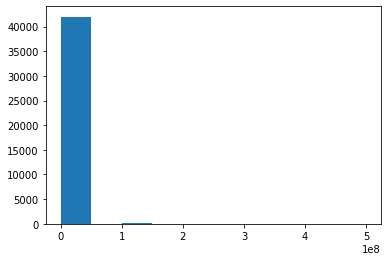

In [186]:
plt.hist(df.purchase)  ### ile klienci wydali w ciągu ostatnich 2 miesięcy

(array([3.9239e+04, 4.1800e+02, 1.3590e+03, 8.0600e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1000e+01, 1.6000e+02]),
 array([ 0.        ,  2.00281167,  4.00562333,  6.008435  ,  8.01124666,
        10.01405833, 12.01686999, 14.01968166, 16.02249332, 18.02530499,
        20.02811666]),
 <a list of 10 Patch objects>)

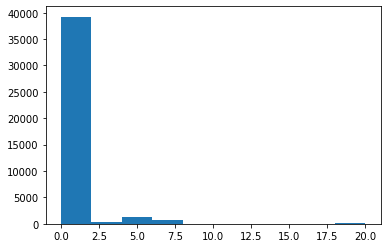

In [187]:
plt.hist(np.log1p(df.purchase)) #zlogarytmowane wydatki miesięczne klientów

# TRZEBA SPRAWDZIĆ CZY COŚ ZE STARSZYCH ANALIZ MOŻE SIĘ PRZYDAĆ

# Dodatkowe analizy eksploracyjne

Ile czynności ooglądania produktu na stronie zakończyło się zakupem?

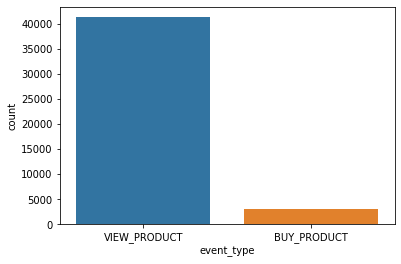

In [3]:
ax = sns.countplot(x="event_type", data=data_df)

Ile razy produktów w ramach sesji uczestnicy oglądali?

(array([2207., 1883., 1216.,  927.,  768.,  700.,  721.,  671.,  602.,
         496.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

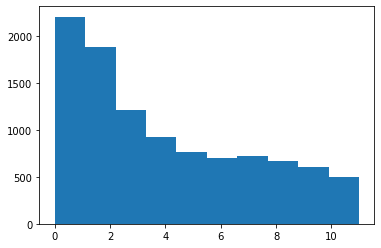

In [4]:
session_product=data_df.groupby(['session_id'])['product_id'].count()
plt.hist(session_product)

In [5]:
session_results=data_df.groupby(['session_id'])['event_type'].min()  #### to check whether it works exactly how I would like it to work

In [6]:
session_prod_event=pd.DataFrame(session_product).join(pd.DataFrame(session_results))
session_prod_event.sort_values(by=['product_id'], inplace=True)  ## it would be good to change column names

### tutaj gdy product_id==0 to oznacza, że w oryginalnych danych było NaN

In [7]:
session_prod_event['event_type']=session_prod_event['event_type'].map({'VIEW_PRODUCT':0, 'BUY_PRODUCT':1})

Text(0, 0.5, 'prawdopodobieństwo zakupu')

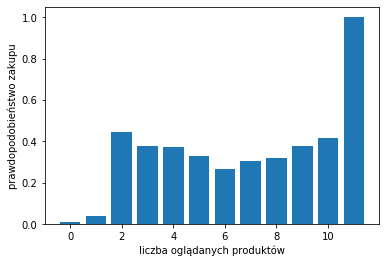

In [8]:
n_prod_buy=session_prod_event.groupby(['product_id'])['event_type'].mean()
plt.bar(n_prod_buy.index, n_prod_buy)
plt.xlabel('liczba oglądanych produktów')
plt.ylabel('prawdopodobieństwo zakupu')

Wstępna analiza pokazuje, że istnieje zależność, że im więcej ktoś przejrzał produktów, tym szansa, że coś kupi wzrasta.

In [9]:
data_df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2022-01-10 00:55:41,102.0,1117.0,VIEW_PRODUCT,10,NaN
1,125,2022-03-08 19:21:47,102.0,1538.0,VIEW_PRODUCT,15,NaN
2,125,2022-03-08 19:23:58,102.0,1539.0,VIEW_PRODUCT,15,NaN
3,125,2022-03-08 19:27:27,102.0,1545.0,VIEW_PRODUCT,15,NaN
4,125,2022-03-08 19:30:22,102.0,1541.0,VIEW_PRODUCT,15,NaN
...,...,...,...,...,...,...,...
44340,10314,2022-01-02 09:36:54,301.0,1628.0,VIEW_PRODUCT,15,NaN
44341,10314,2022-01-02 09:39:43,301.0,1630.0,VIEW_PRODUCT,15,NaN
44342,10314,2022-01-02 09:40:30,301.0,1626.0,VIEW_PRODUCT,15,NaN
44343,10314,2022-01-02 09:42:25,301.0,1634.0,VIEW_PRODUCT,15,NaN


## Analiza czasu trwania sesji

In [10]:
diff_time=data_df.groupby(['session_id'])['timestamp'].max()-data_df.groupby(['session_id'])['timestamp'].min()

In [11]:
d=pd.DataFrame(diff_time)
d=d.reset_index()
d.columns=['session_id', 'time_diff']

### w ramce danych do modelowania należy dać informację, ile całkowicie trwała sesja oraz ile produktów obejrzano

In [12]:
d=d.sort_values(['time_diff'])
d.index=d.session_id

In [13]:
session_results=session_results.map({'VIEW_PRODUCT':0, 'BUY_PRODUCT':1})

In [14]:
d=d.join(session_results)
d.drop('session_id', axis=1, inplace=True)

In [15]:
d

,time_diff,event_type
session_id,,
124,00:00:00,0
4578,00:00:00,0
4587,00:00:00,0
4588,00:00:00,0
4589,00:00:00,0
...,...,...
4709,00:35:07,0
8522,00:35:27,1
4698,00:35:53,1


In [16]:
d['time_diff'] = d['time_diff'].apply(lambda x: x.seconds)

Text(0.5, 0, 'czas trwania sesji')

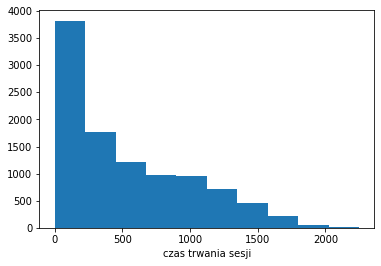

In [17]:
plt.hist(d['time_diff'])
plt.xlabel('czas trwania sesji')

In [251]:
## Warto byłoby dodać wizualizację jaka jest relacja między czasem trwania sesji a zakupem 

## Dodatkowe analizy

Ile razy dany produkt był kupiony?

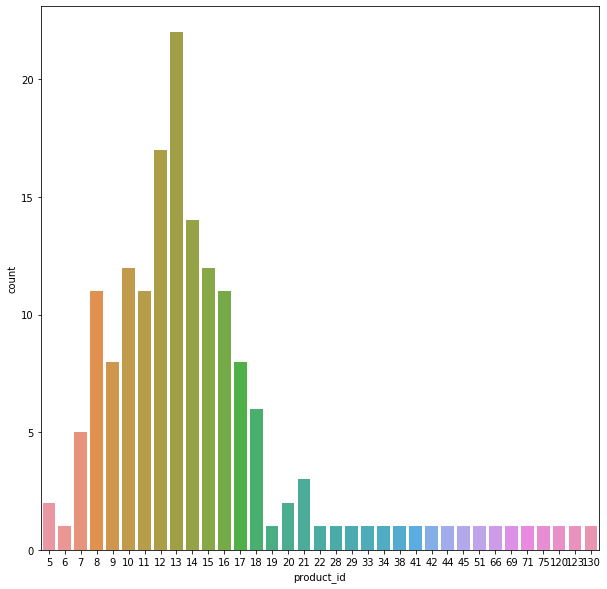

In [252]:
plt.figure(figsize=(10,10))
sns.countplot(data_df[data_df.event_type=='BUY_PRODUCT'].groupby('product_id')['product_id'].count())

Jaki jest najwyższy współczynnik liczby sprzedaży danego produktu liczby jego oglądania?

In [253]:
df_tmp.groupby('product_id')['event_type'].mean().max()

0.23722627737226276

# Braki w danych

In [254]:
3097/44345 

0.06983876423497576

Wniosek: Braki występują w kolumnach: *used_id*, *product_id* oraz *purchase_id*. Było to uwidocznione w pierwsze analizie po wczytaniu danych. Szczególnie dużo jest ich w ostatnio wymienionej kolumnie, gdzie tylko ok. 7% rekordów ma zdefiniowaną wartość. W przypadku pozostałych kolumn braki stanowią jedynie ok. 5\%.

Zweryfikowano czy duża liczba braków w kolumnie *purchase_id* wynika z tego, że niewielka liczba sesji polegających na oglądaniu konkretnego produktu zakończyła się zakupem. 

In [255]:
df_view_prod=data_df[data_df['event_type']=='VIEW_PRODUCT']

np.sum(np.isnan(df_view_prod.purchase_id))/len(df_view_prod)

1.0

Okazuje się, że brak wartości w kolumnie *purchase_id* wynika z braku zakupu. Braki więc nie mają charakteru losowego, a wynikają z charakteru i logiki danych. 

W tej sytuacji można byłoby zamienić braki na wartość neutralną, czyli taką jaka nie występuje w kolumnie *purchase_id* - np. 0 albo -1.

In [256]:
data_df[data_df.user_id.isnull()]

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
66,142,2022-01-06 10:26:05,NaN,1436.0,VIEW_PRODUCT,0,NaN
84,145,2022-03-07 04:31:22,NaN,1095.0,VIEW_PRODUCT,10,NaN
111,152,2022-02-14 02:53:27,NaN,1095.0,VIEW_PRODUCT,5,NaN
128,156,2022-03-13 10:37:35,NaN,1117.0,VIEW_PRODUCT,5,NaN
151,160,2022-01-26 03:28:04,NaN,1619.0,VIEW_PRODUCT,0,NaN
...,...,...,...,...,...,...,...
44148,10271,2022-01-12 16:59:26,NaN,1160.0,VIEW_PRODUCT,0,NaN
44239,10293,2022-01-13 07:37:54,NaN,1538.0,VIEW_PRODUCT,20,NaN
44286,10302,2022-03-10 14:29:51,NaN,1600.0,VIEW_PRODUCT,20,NaN
44308,10307,2022-02-21 09:13:30,NaN,1093.0,VIEW_PRODUCT,5,NaN


In [257]:
data_df[data_df.product_id.isnull()]

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
18,129,2022-01-18 14:14:16,102.0,NaN,VIEW_PRODUCT,15,NaN
19,129,2022-01-18 14:18:32,102.0,NaN,VIEW_PRODUCT,15,NaN
29,130,2022-03-16 21:35:40,102.0,NaN,VIEW_PRODUCT,10,NaN
47,136,2022-03-21 14:59:29,102.0,NaN,VIEW_PRODUCT,15,NaN
102,150,2022-01-25 09:19:25,102.0,NaN,VIEW_PRODUCT,0,NaN
...,...,...,...,...,...,...,...
44175,10276,2022-02-04 19:10:02,301.0,NaN,VIEW_PRODUCT,5,NaN
44240,10293,2022-01-13 07:41:16,301.0,NaN,VIEW_PRODUCT,20,NaN
44273,10300,2022-03-17 04:26:48,301.0,NaN,VIEW_PRODUCT,10,NaN
44275,10300,2022-03-17 04:29:55,301.0,NaN,VIEW_PRODUCT,10,NaN


Nie widać jasnego powodu dlaczego w ok. 5% przypadków występuje brak w kolumnie *user_id* i *product_id*, dlatego też nie podejrzewa się informatywnego błędu systematycznego. **W tej sytuacji wiersze z brakami w tymi kolumnach podda się usunięciu.**

In [258]:
data_df=data_df[data_df.user_id.notnull()]
data_df=data_df[data_df.product_id.notnull()]
data_df.shape

(40081, 7)

Można by było też zamienić na jakieś wartości, ale skoro braków jest mało, to chyba mała strata.

Liczba użytkowników:

In [259]:
len(np.unique(data_df.user_id))

200

Liczba sesji:

In [260]:
len(np.unique(data_df.session_id))

9972

Liczba produktów:

In [261]:
len(np.unique(data_df.product_id))

164

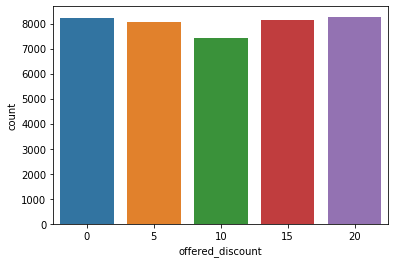

In [262]:
ax = sns.countplot(x="offered_discount", data=data_df)

# Time analysis

There is no information about time zone therefore we assume that everything is in the same timezone.

In [263]:
data_df['timestamp']=pd.to_datetime(data_df.timestamp)

In [264]:
data_df['date']=data_df['timestamp'].dt.date

In [265]:
data_df['time']=data_df['timestamp'].dt.time
data_df['day']=data_df['timestamp'].dt.day
data_df['month']=data_df['timestamp'].dt.month
data_df['year']=data_df['timestamp'].dt.year

#data_df.drop('timestamp', axis=1, inplace=True)

In [266]:
np.unique(data_df.year)

array([2022], dtype=int64)

Wszystkie rekordy są z tego samego roku, więc informacja o roku nic nie wnosi i można ją usunąć.

In [267]:
np.unique(data_df.month)

array([1, 2, 3], dtype=int64)

Informacje są tylko z pierwszego kwartału 2022r. 

In [268]:
print(pd.date_range(
  start="2022-01-01", end="2022-03-31").difference(data_df.date))

DatetimeIndex(['2022-03-29', '2022-03-30', '2022-03-31'], dtype='datetime64[ns]', freq=None)


Okazuje się, że informacja nie jest z całych trzech miesięcy, tj. kończy się w dniu 28-03-2022.

In [269]:
data_df['timestamp'][0].strftime("%w")  # day of week  -- transform in such a way to df

'1'

In [270]:
# we should have both info about day of week and day of month

In [271]:
data_df['hour']=data_df['timestamp'].dt.hour

In [272]:
### hour, day of week, day of month - we will cyclic feature encoding

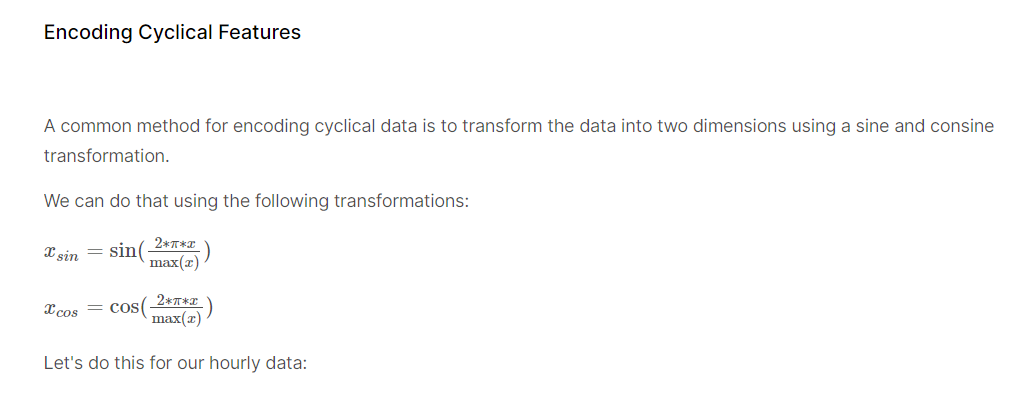

https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook

In [273]:
data_df['hour_sin'] = np.sin(2 * np.pi * data_df['hour']/23.0)
data_df['hour_cos'] = np.cos(2 * np.pi * data_df['hour']/23.0)

In [274]:
data_df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,date,time,day,month,year,hour,hour_sin,hour_cos
0,124,2022-01-10 00:55:41,102.0,1117.0,VIEW_PRODUCT,10,NaN,2022-01-10,00:55:41,10,1,2022,0,0.000000,1.000000
1,125,2022-03-08 19:21:47,102.0,1538.0,VIEW_PRODUCT,15,NaN,2022-03-08,19:21:47,8,3,2022,19,-0.887885,0.460065
2,125,2022-03-08 19:23:58,102.0,1539.0,VIEW_PRODUCT,15,NaN,2022-03-08,19:23:58,8,3,2022,19,-0.887885,0.460065
3,125,2022-03-08 19:27:27,102.0,1545.0,VIEW_PRODUCT,15,NaN,2022-03-08,19:27:27,8,3,2022,19,-0.887885,0.460065
4,125,2022-03-08 19:30:22,102.0,1541.0,VIEW_PRODUCT,15,NaN,2022-03-08,19:30:22,8,3,2022,19,-0.887885,0.460065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44340,10314,2022-01-02 09:36:54,301.0,1628.0,VIEW_PRODUCT,15,NaN,2022-01-02,09:36:54,2,1,2022,9,0.631088,-0.775711
44341,10314,2022-01-02 09:39:43,301.0,1630.0,VIEW_PRODUCT,15,NaN,2022-01-02,09:39:43,2,1,2022,9,0.631088,-0.775711
44342,10314,2022-01-02 09:40:30,301.0,1626.0,VIEW_PRODUCT,15,NaN,2022-01-02,09:40:30,2,1,2022,9,0.631088,-0.775711
44343,10314,2022-01-02 09:42:25,301.0,1634.0,VIEW_PRODUCT,15,NaN,2022-01-02,09:42:25,2,1,2022,9,0.631088,-0.775711


# Analiza zniżek

(array([9115.,    0.,    0.,    0.,    0., 8965.,    0.,    0.,    0.,
           0., 8139.,    0.,    0.,    0.,    0., 8993.,    0.,    0.,
           0., 9133.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

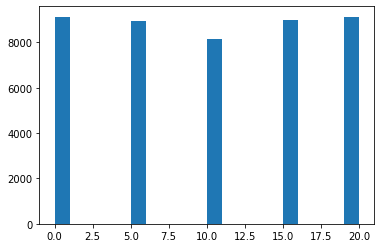

In [24]:
plt.hist(data_df['offered_discount'], bins=20)

<BarContainer object of 5 artists>

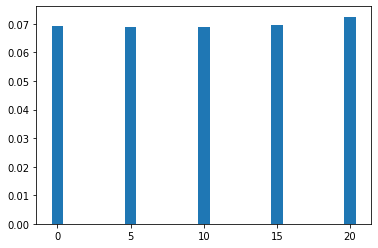

In [31]:
data_df['event_type']=data_df['event_type'].map({'VIEW_PRODUCT':0, 'BUY_PRODUCT':1})
discount_buy=data_df.groupby(['offered_discount'])['event_type'].mean()
plt.bar(discount_buy.index, discount_buy)

(array([ 4.,  4., 16., 72., 74., 24.,  3.,  2.,  0.,  1.]),
 array([ 3.38383838,  5.04545455,  6.70707071,  8.36868687, 10.03030303,
        11.69191919, 13.35353535, 15.01515152, 16.67676768, 18.33838384,
        20.        ]),
 <a list of 10 Patch objects>)

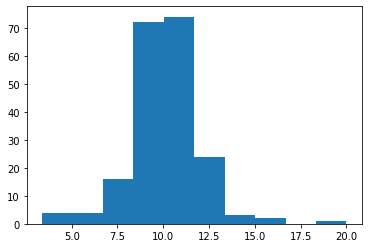

In [33]:
discount_user=data_df.groupby(['user_id'])['offered_discount'].mean()
plt.hist(discount_user)